In [260]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [261]:
from math import sqrt, cos, sin, degrees, radians, isnan
# Idea is to do a descent to find the solution to the problem. There is a long math solution according to wolfram alpha, but I don't want to do that.
# Basically in the angle we are interested in, the problem is convex
# We could calculated the derivative, but let's do a binary search instead

# All units in centimeters
MALLET_LENGTH = 41.11 # a
AXIS_MOVEABLE_DISTANCE = 0.75 # c
MOVEABLE_FIX_DISTANCE = 4.25
AXIS_FIX_DISTANCE = AXIS_MOVEABLE_DISTANCE + MOVEABLE_FIX_DISTANCE # b
MIN_ANGLE = radians(-5)
MAX_ANGLE = radians(85)

def angle_based_distance(angle):
    # sqrt((cos(phi)a-sin(phi)c-a)^2 + (sin(phi)a+cos(phi)c-b)^2)
    angle = -angle # inverted angle in the model
    return sqrt(
        (cos(angle) * MALLET_LENGTH - sin(angle) * AXIS_MOVEABLE_DISTANCE - MALLET_LENGTH)**2
        + (sin(angle) * MALLET_LENGTH + cos(angle) * AXIS_MOVEABLE_DISTANCE - AXIS_FIX_DISTANCE)**2
    )

def solve_for_input_distance(distance):
    # Otherwise we get a endless loop
    if isnan(distance):
        return None
    
    # Binary search
    min_angle = MIN_ANGLE
    max_angle = MAX_ANGLE
    prev_error = 0
    iterations = 0
    while True:
        iterations += 1
        angle = (min_angle + max_angle) / 2
        calculated_distance = angle_based_distance(angle)
        error = abs(distance - calculated_distance)
        if abs(prev_error - error) < 0.0001:
            #print("Solution not found")
            #print("Iterations: {}".format(iterations))
            return None
        prev_error = error
        if error < 0.0001:
            #print("Found angle: {} degrees".format(degrees(angle)))
            #print("Iterations: {}".format(iterations))
            return degrees(angle)
        elif calculated_distance > distance:
            max_angle = angle
        else:
            min_angle = angle

In [262]:
def analyse(pos_data: pd.DataFrame, measured_data: pd.DataFrame, debug=False, only_diff=False):
    if not only_diff:
        pos_data.plot(x="time", y="pos")
        measured_data.plot(x="time", y="angle")
    
    # Sample pos data at measured data timestamps (pos data is command)
    for i in range(measured_data.shape[0]):
        measured_data.loc[i, "pos"] = pos_data[pos_data["time"] < measured_data.loc[i, "time"]].iloc[-1]["pos"]
    
    measured_data["diff"] = measured_data["pos"] - measured_data["angle"]
    min_x = measured_data["time"].min()
    max_x = measured_data["time"].max()
    
    na_md = measured_data[measured_data["diff"].notna()]
    
    #knr = KNeighborsRegressor(n_neighbors=25, weights="distance")
    #knr = knr.fit(na_md["time"].values.reshape(-1, 1), na_md["diff"])
    center_x = na_md["time"].mean()
    model = make_pipeline(PolynomialFeatures(12, include_bias=False), Ridge(alpha=0.7))
    model.fit((na_md["time"] - center_x).values.reshape(-1, 1), na_md["diff"].values.reshape(-1, 1))
    
    x = np.linspace(min_x - center_x, max_x - center_x, len(measured_data))
    pred_y = model.predict(x.reshape(-1, 1))
    measured_data["smoothed_diff"] = pred_y
    measured_data.plot(x="time", y=["diff", "smoothed_diff"])
    

In [263]:
def distance_to_angles(measured_distances: pd.DataFrame):
    solve_func = np.vectorize(solve_for_input_distance)
    # Distance was given in millimeters
    measured_distances["distance_cm"] = measured_distances["distance"] / 10
    measured_distances["angle"] = solve_func(measured_distances["distance_cm"])
    print("Couldn't find values for", measured_distances["angle"].isna().sum(), "values")
    return measured_distances
    

In [264]:
pos_data_list = []
measured_distances_list = []
for i in range(1, 6):
    pos_data = pd.read_csv(f"calibration_pos-{i}.csv", header=None, names=["time", "pos"])
    measured_distances = pd.read_csv(f"calibration-distance-{i}-cleaned.csv", header=None, names=["time", "distance"])
    # Remap to 0 to 70
    pos_data["pos"] = -(pos_data["pos"] - 140)
    pos_data_list.append(pos_data)
    measured_distances_list.append(measured_distances)
    
# First Run
#pos_data = pd.read_csv("calibration_pos-1.csv", header=None, names=["time", "pos"])
#measured_distances = pd.read_csv("calibration-distance-1-cleaned.csv", header=None, names=["time", "distance"])

# Second Run
#pos_data2 = pd.read_csv("calibration_pos-2.csv", header=None, names=["time", "pos"])
#measured_distances2 = pd.read_csv("calibration-distance-2-cleaned.csv", header=None, names=["time", "distance"])

# Remap to 0 to 70
#pos_data["pos"] = -(pos_data["pos"] - 140)
#pos_data2["pos"] = -(pos_data2["pos"] - 140)

In [265]:
# Add angles to data
start_time = time.time()
[distance_to_angles(measured_distances) for measured_distances in measured_distances_list]
#measured_distances = distance_to_angles(measured_distances)
#measured_distances2 = distance_to_angles(measured_distances2)
end_time = time.time()
print("Time to convert distances to angles:", end_time - start_time)

Couldn't find values for 2213 values
Couldn't find values for 1989 values
Couldn't find values for 772 values
Couldn't find values for 805 values
Couldn't find values for 787 values
Time to convert distances to angles: 0.23062801361083984


c:\Users\tschm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.17431e-53): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


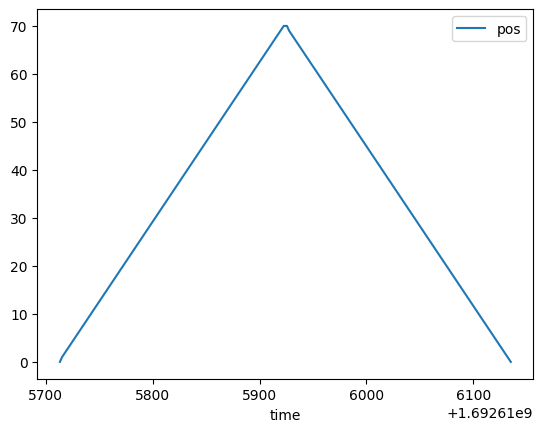

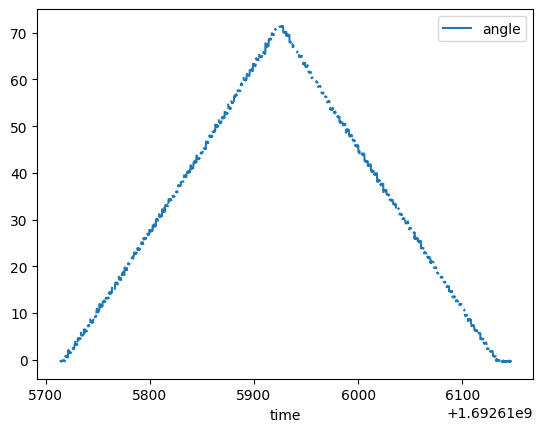

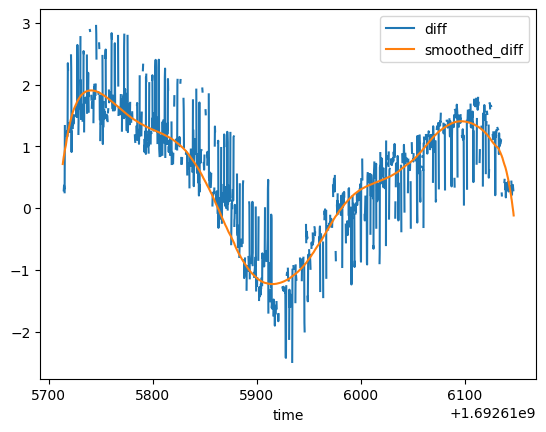

In [266]:
# Detailed plotting
select = 3
analyse(pos_data_list[select], measured_distances_list[select])

c:\Users\tschm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.17857e-53): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\tschm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.43946e-53): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\tschm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.79604e-53): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\tschm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.17431e-53): result may not be accurate.
  return linalg.solve

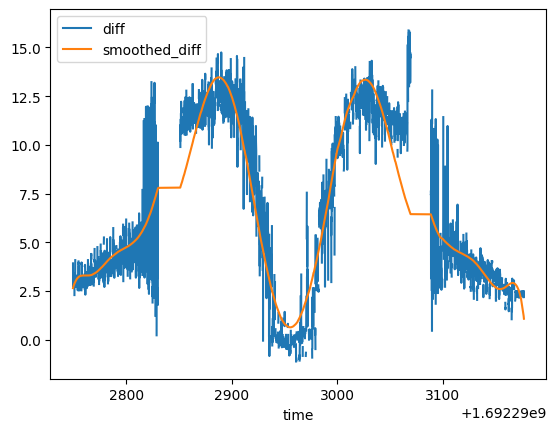

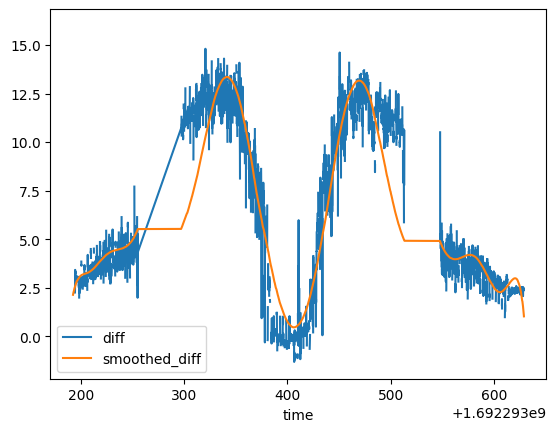

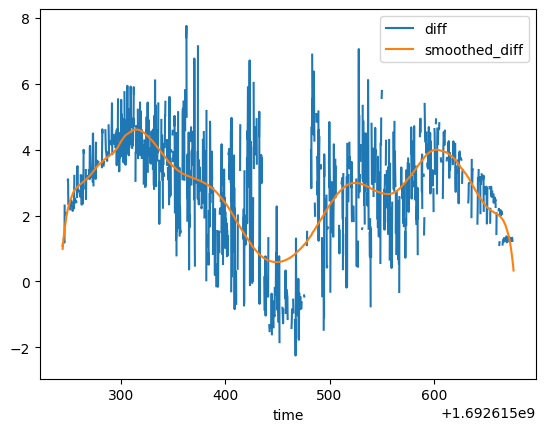

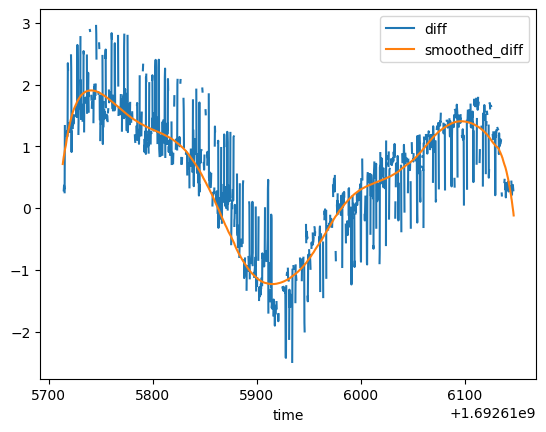

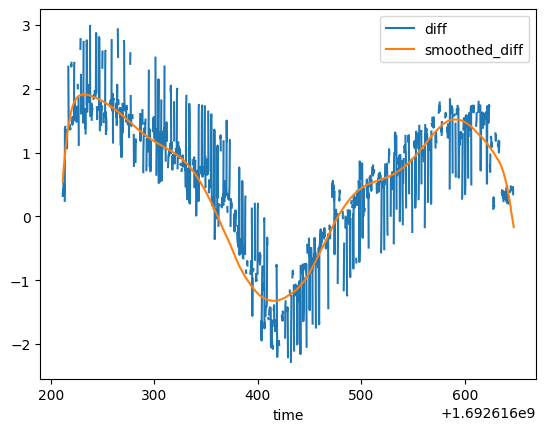

In [267]:
for i in range(len(pos_data_list)):
    analyse(pos_data_list[i], measured_distances_list[i], only_diff=True)

C:\Users\tschm\AppData\Local\Temp\ipykernel_12836\2622638621.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na_md["pred_diff"] = pred_y
C:\Users\tschm\AppData\Local\Temp\ipykernel_12836\2622638621.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na_md["pred_diff"] = pred_y
C:\Users\tschm\AppData\Local\Temp\ipykernel_12836\2622638621.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

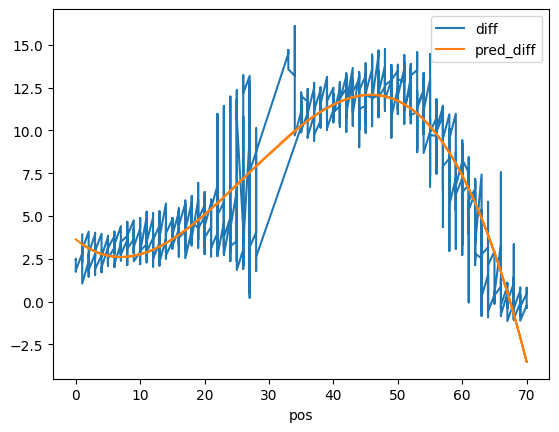

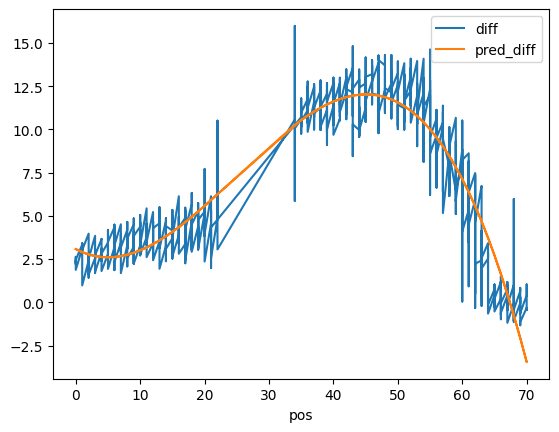

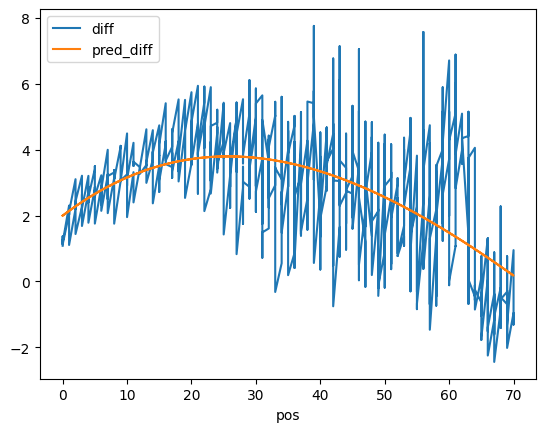

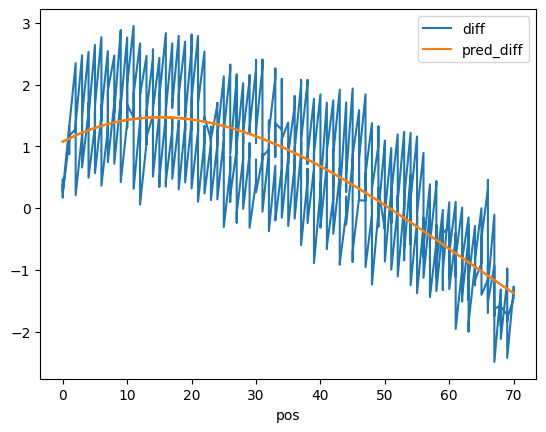

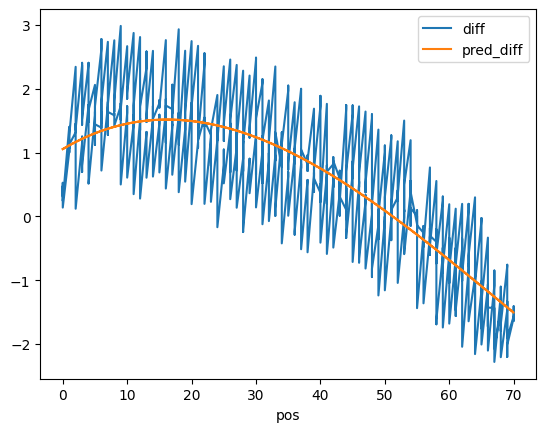

In [268]:
# Potential correction function

def regress_correction_function(measured_data: pd.DataFrame):
    na_md = measured_data[measured_data["diff"].notna()]
    model = make_pipeline(PolynomialFeatures(3, include_bias=False), Ridge(alpha=0.7))
    model.fit(na_md["pos"].values.reshape(-1, 1), na_md["diff"].values.reshape(-1, 1))
    min_x = na_md["pos"].min()
    max_x = na_md["pos"].max()
    
    x = np.linspace(min_x, max_x, len(na_md))
    pred_y = model.predict(na_md["pos"].values.reshape(-1, 1))
    na_md["pred_diff"] = pred_y
    na_md.plot(x="pos", y=["diff", "pred_diff"])

for i in range(len(measured_distances_list)):
    regress_correction_function(measured_distances_list[i])